# Artificial Neural Networks and Deep Learning - Homework 2


## 🌐 Connect Colab to Google Drive

In [1]:
# from google.colab import drive

# drive.mount("/gdrive")
# %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2024-12-04 18:19:58.304325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 18:19:58.340220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 18:19:58.350519: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 18:19:58.377474: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 18:19:59.918059: W tensorflow/compiler/tf2

TensorFlow version: 2.17.0
Keras version: 3.4.1
GPU devices: 1


I0000 00:00:1733332804.014814  114526 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733332804.105033  114526 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733332804.106681  114526 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## ⏳ Load and prepare the Data

In [3]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [4]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [5]:
# Remove outliers (containing aliens)
outliers = [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
X_train = np.delete(X_train, outliers, axis=0)
y_train = np.delete(y_train, outliers, axis=0)

# Print the new shape
print(f"Training X shape after outlier removal: {X_train.shape}")
print(f"Training y shape after outlier removal: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape after outlier removal: (2505, 64, 128, 1)
Training y shape after outlier removal: (2505, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [6]:
# Split into training and validation (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=seed, test_size=0.2
)

In [7]:
category_map = {
    0: 0,  # background
    1: 1,  # soil
    2: 2,  # bedrock
    3: 3,  # sand
    4: 4,  # big rock
}


def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), default_value=0
    )
    return table.lookup(label)

In [8]:
@tf.function
def random_flip_h(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_left_right(label), lambda: label
    )
    return image, label

@tf.function
def random_flip_v(image, label, seed=None):
    """Consistent random vertical flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_up_down(image), lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5, lambda: tf.image.flip_up_down(label), lambda: label
    )
    return image, label

@tf.function
def augmentation(image, label, seed=None):
    image, label = random_flip_h(image, label, seed)
    image, label = random_flip_v(image, label, seed+1)
    return image, label

In [9]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Add an axis to labels
    new_labels = labels[..., np.newaxis]

    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((images, new_labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)), num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: augmentation(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE,
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [10]:
batch_size = 32

# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train,
    y_train.astype("int32"),
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    seed=seed,
)

val_dataset = make_dataset(
    X_val, y_val.astype("int32"), batch_size=batch_size, shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...


I0000 00:00:1733332808.200434  114526 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733332808.202437  114526 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733332808.204079  114526 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733332808.432723  114526 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


## Analyze the data

Visualizing examples from the training set:


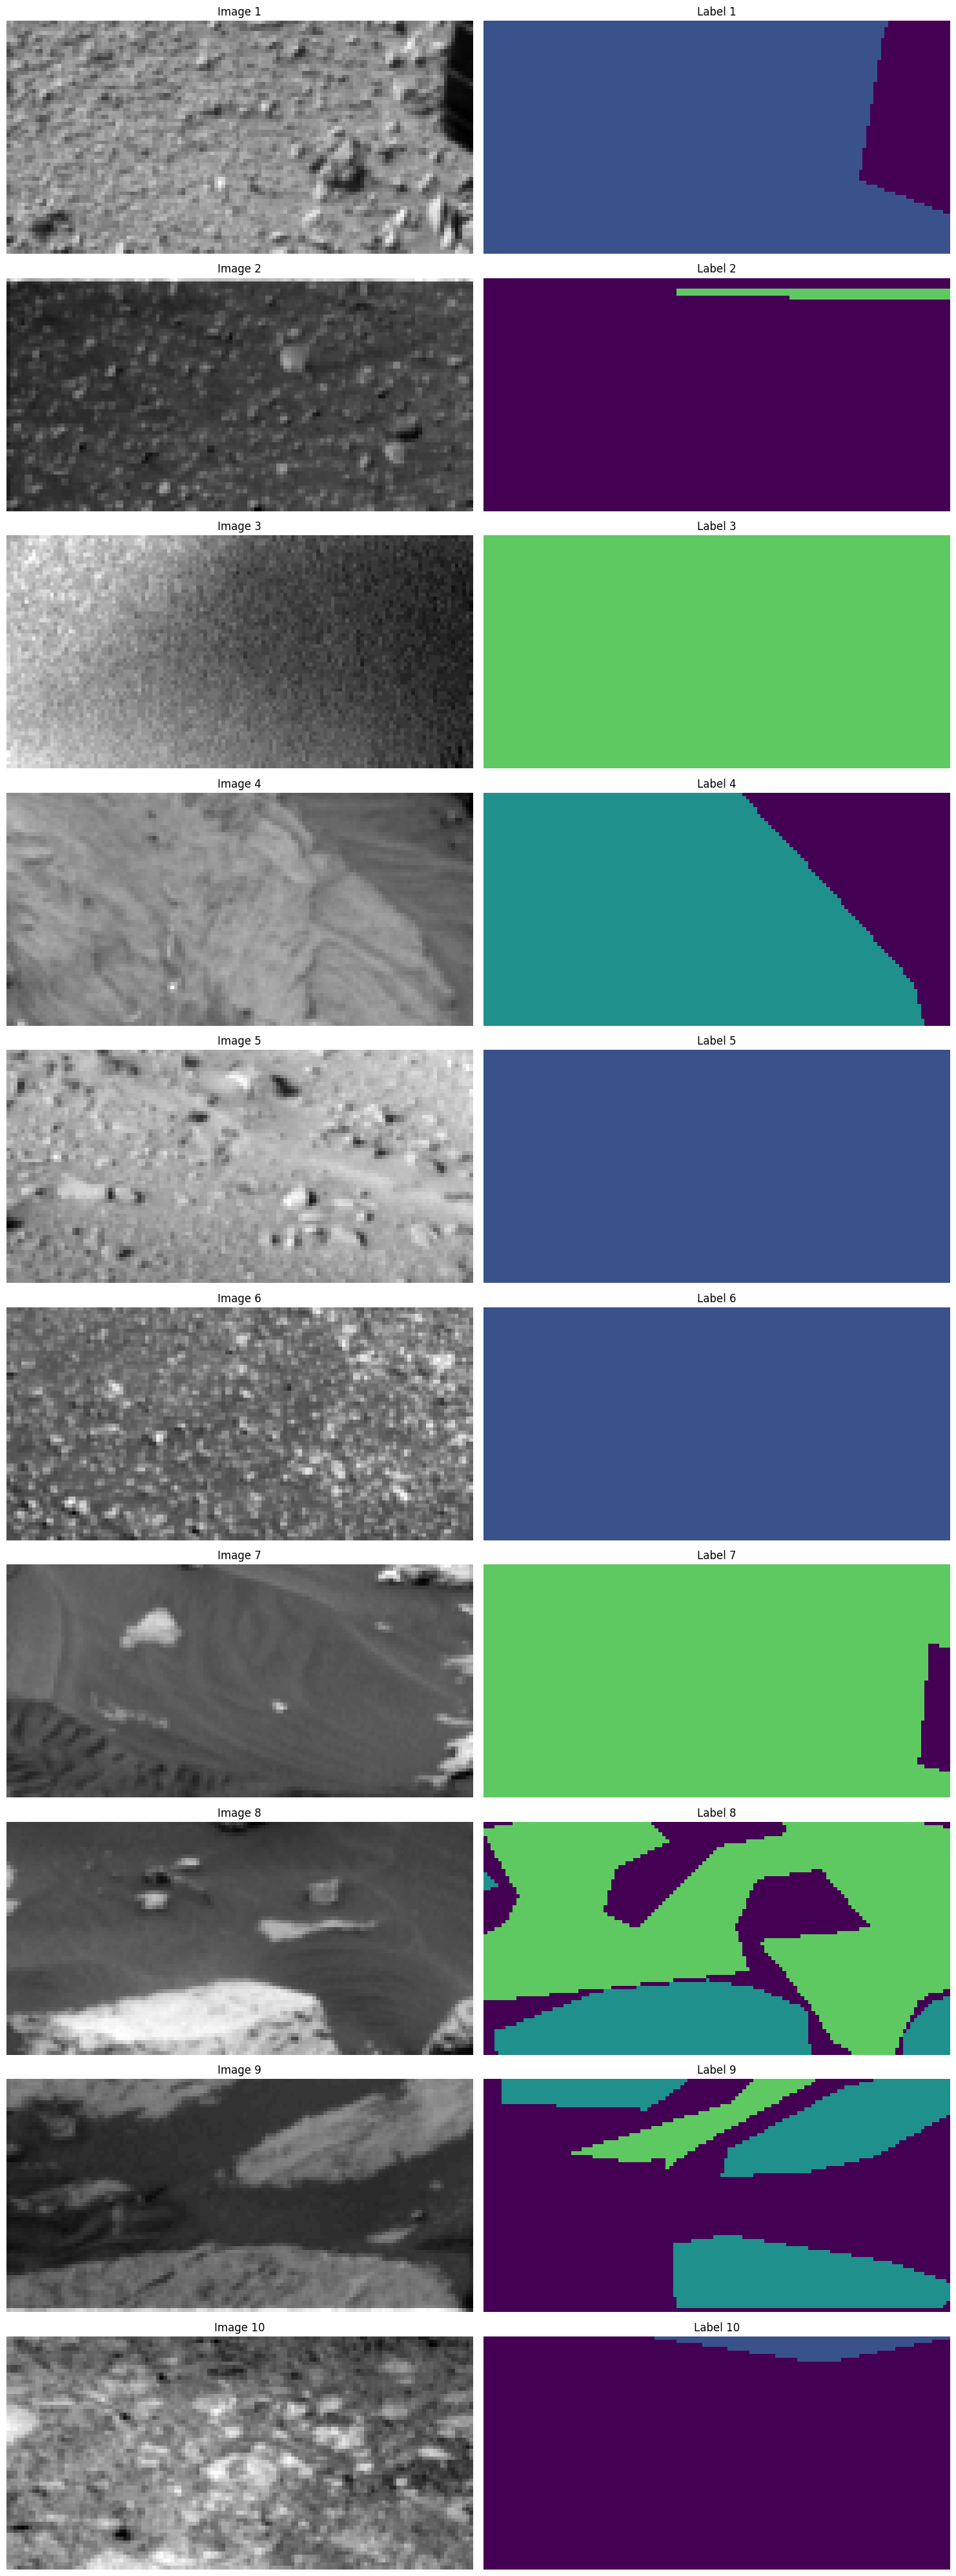

In [11]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))


def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored


def plot_sample_batch(images, labels, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    colormap = create_segmentation_colormap(num_classes)

    for j in range(min(num_samples, len(images))):
        # Plot original image
        plt.subplot(num_samples, 2, j * 2 + 1)
        plt.imshow(images[j], cmap="grey")
        plt.title(f"Image {j+1}")
        plt.axis("off")

        # Plot colored label
        plt.subplot(num_samples, 2, j * 2 + 2)
        colored_label = apply_colormap(labels[j], colormap)
        plt.imshow(colored_label)
        plt.title(f"Label {j+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()


# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(X_train, y_train, num_samples=10)

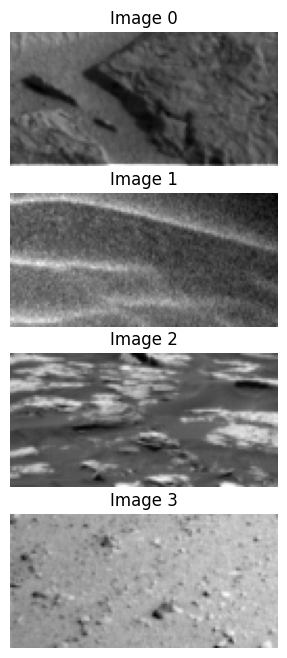

In [12]:
# Visualize examples from the test set.
num_samples = 4
plt.figure(figsize=(15, 2 * num_samples))

colormap = create_segmentation_colormap(num_classes)

for j in range(min(num_samples, len(X_test))):
    plt.subplot(num_samples, 1, j + 1)
    plt.imshow(X_test[j], cmap="grey")
    plt.title(f"Image {j}")
    plt.axis("off")

## 🛠️ Define the model

In [13]:
def unet_block(
    input_tensor, filters, kernel_size=3, activation="relu", stack=2, name=""
):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(
            filters,
            kernel_size=kernel_size,
            padding="same",
            name=name + "conv" + str(i + 1),
        )(x)
        x = tfkl.BatchNormalization(name=name + "bn" + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + "activation" + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [14]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name="down_block1_")
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name="down_block2_")
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name="bottleneck")

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name="up_block1_")

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name="up_block2_")

    # Output Layer
    output_layer = tfkl.Conv2D(
        num_classes,
        kernel_size=1,
        padding="same",
        activation="softmax",
        name="output_layer",
    )(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="UNet")
    return model

In [15]:
# Define parameters
epochs = 1000
patience = 20
learning_rate = 1e-4

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckconv1   │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckbn1     │ (None, 16, 32,  │       512 │ bottleneckcon… │   Y 

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

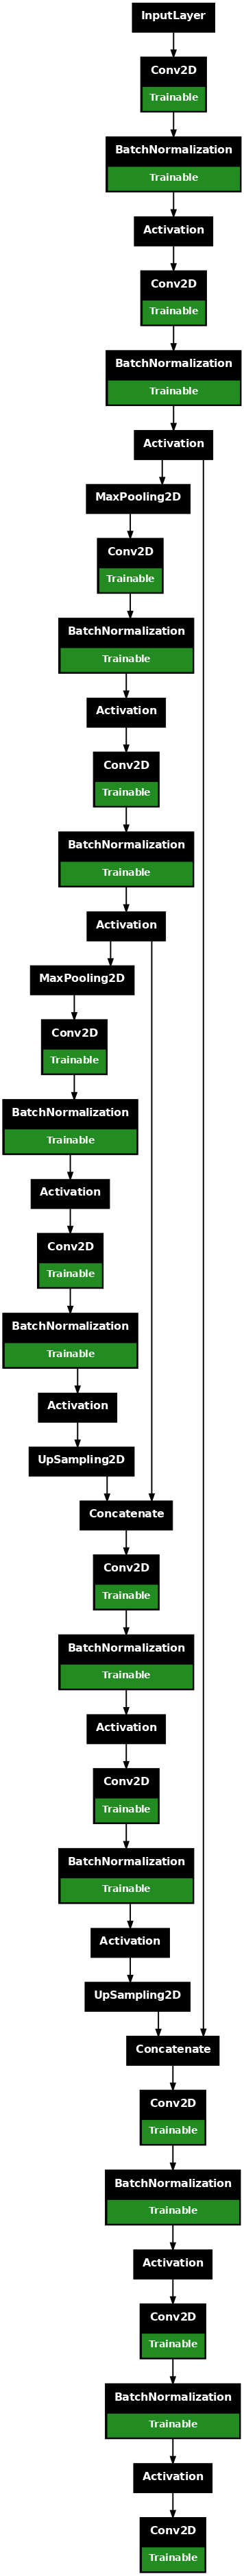

In [16]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

## Train the model

In [17]:
# Define custom Mean Intersection Over Union metric
@tfk.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(
        self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None
    ):
        super(MeanIntersectionOverUnion, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label
            label = apply_category_mapping(label)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="grey")
            plt.title("Input Image")
            plt.axis("off")

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis("off")

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
            plt.close()

In [18]:
# Define a custom loss
class CustomLoss(tfk.losses.Loss):
    def __init__(self, alpha, name='custom_loss', **kwargs):
        super(CustomLoss, self).__init__(name=name, **kwargs)
        self.alpha = alpha
        self.focal = tfk.losses.CategoricalFocalCrossentropy()
        self.dice = tfk.losses.Dice()

    def call(self, y_true, y_pred):
        # Calculate the cross-entropy loss
        return (1-self.alpha)*self.focal.call(y_true, y_pred)+self.alpha*self.dice.call(y_true, y_pred)

In [19]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=[
        "accuracy",
        MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0]),
    ],
)
print("Model compiled!")

Compiling model...
Model compiled!


In [20]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_iou", mode="max", patience=patience, restore_best_weights=True
)

image, label = val_dataset.take(1).get_single_element()
viz_callback = VizCallback(image[11:12, ...], label[11:12, ...])

reduce_lr_callback = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss", patience=patience / 2, factor=0.1, min_lr=learning_rate / 100
)

callbacks = [early_stopping, viz_callback, reduce_lr_callback]

Epoch 1/1000


I0000 00:00:1733332827.455421  114723 service.cc:146] XLA service 0x79f53c00a8f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733332827.455516  114723 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-12-04 18:20:27.855243: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1733332834.152953  114723 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-12-04 18:20:34.877570: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1733332838.084553  114723 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:

 2/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.1805 - loss: 2.0495 - mean_iou: 0.0808 

I0000 00:00:1733332849.935981  114723 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3119 - loss: 1.6990 - mean_iou: 0.1482

W0000 00:00:1733332857.829037  114723 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1733332860.713390  114723 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733332861.017669  114723 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733332861.901522  114723 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1733332862.228503  114723 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:17

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.3131 - loss: 1.6965 - mean_iou: 0.1488

W0000 00:00:1733332878.811669  114722 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733332884.954673  114724 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


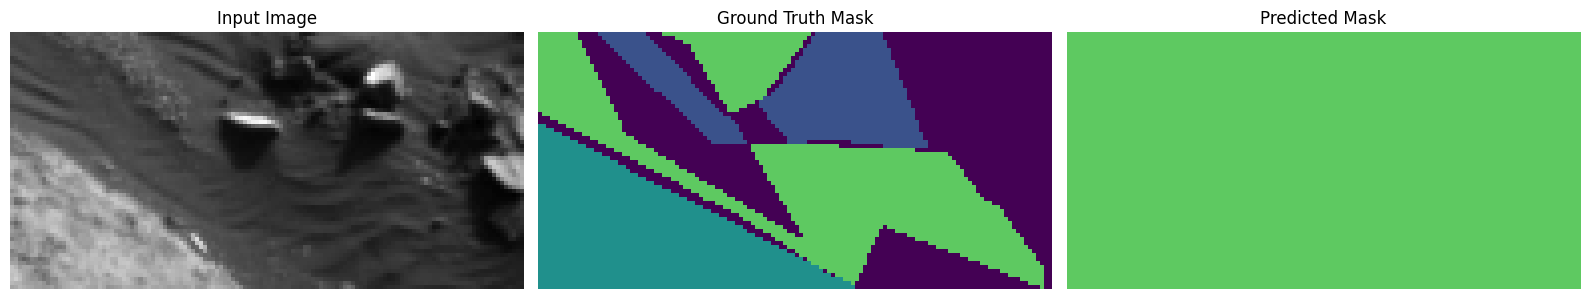

63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 644ms/step - accuracy: 0.3143 - loss: 1.6941 - mean_iou: 0.1494 - val_accuracy: 0.1979 - val_loss: 2.0280 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5255 - loss: 1.3054 - mean_iou: 0.2674 - val_accuracy: 0.1979 - val_loss: 2.7936 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5799 - loss: 1.1929 - mean_iou: 0.3125 - val_accuracy: 0.1979 - val_loss: 3.4537 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 4/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5901 - loss: 1.1346 - mean_iou: 0.3171 - val_accuracy: 0.1979 - val_loss: 4.4793 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 5/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6085 - loss: 1.0815 - mean_iou: 0.3326 - val_accuracy: 0.1979 - val_loss: 4.5030 - val_mean_iou: 0.0656 - learning_rate: 1.0000e-04
Epoch 6/1000
62/

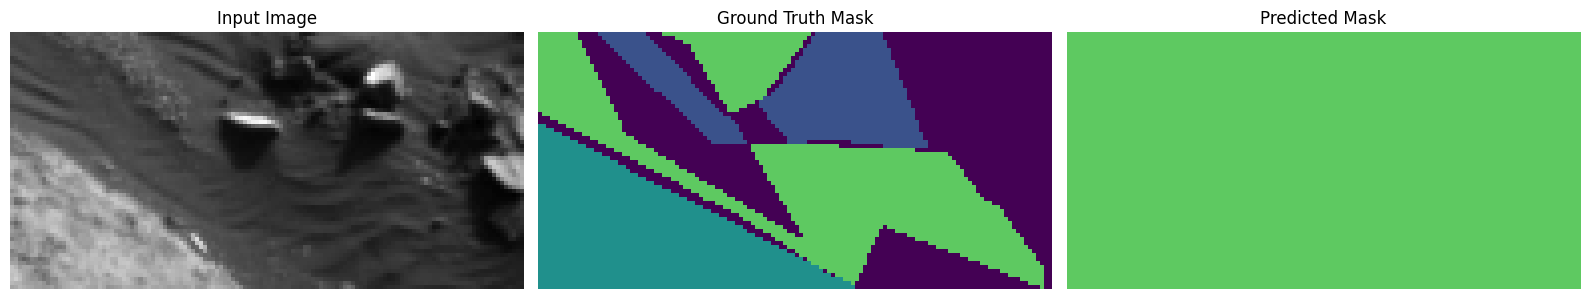

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6265 - loss: 1.0415 - mean_iou: 0.3485 - val_accuracy: 0.1983 - val_loss: 4.1810 - val_mean_iou: 0.0525 - learning_rate: 1.0000e-04
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6365 - loss: 1.0050 - mean_iou: 0.3552 - val_accuracy: 0.2022 - val_loss: 3.6011 - val_mean_iou: 0.0544 - learning_rate: 1.0000e-04
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6417 - loss: 0.9828 - mean_iou: 0.3613 - val_accuracy: 0.2610 - val_loss: 2.4391 - val_mean_iou: 0.0963 - learning_rate: 1.0000e-04
Epoch 9/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6468 - loss: 0.9755 - mean_iou: 0.3658 - val_accuracy: 0.4062 - val_loss: 1.6767 - val_mean_iou: 0.1814 - learning_rate: 1.0000e-04
Epoch 10/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6386 - loss: 0.9865 - mean_iou: 0.3596 - val_accuracy: 0.5110 - val_loss: 1.3005 - val_mean_iou: 0.2643 - learning_rate: 1.0000e-04
Epoch 11/1000
62/

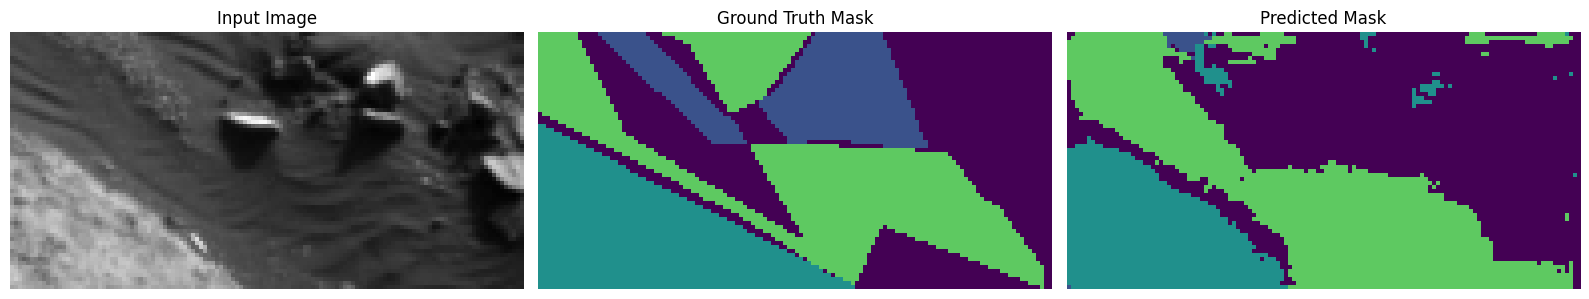

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6559 - loss: 0.9382 - mean_iou: 0.3715 - val_accuracy: 0.5042 - val_loss: 1.3163 - val_mean_iou: 0.2494 - learning_rate: 1.0000e-04
Epoch 12/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6567 - loss: 0.9298 - mean_iou: 0.3709 - val_accuracy: 0.6054 - val_loss: 1.0785 - val_mean_iou: 0.3321 - learning_rate: 1.0000e-04
Epoch 13/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6622 - loss: 0.9084 - mean_iou: 0.3765 - val_accuracy: 0.6595 - val_loss: 0.9617 - val_mean_iou: 0.3780 - learning_rate: 1.0000e-04
Epoch 14/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6642 - loss: 0.9095 - mean_iou: 0.3794 - val_accuracy: 0.6325 - val_loss: 0.9900 - val_mean_iou: 0.3481 - learning_rate: 1.0000e-04
Epoch 15/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6752 - loss: 0.8763 - mean_iou: 0.3945 - val_accuracy: 0.6724 - val_loss: 0.9060 - val_mean_iou: 0.3827 - learning_rate: 1.0000e-04
Epoch 16/1000


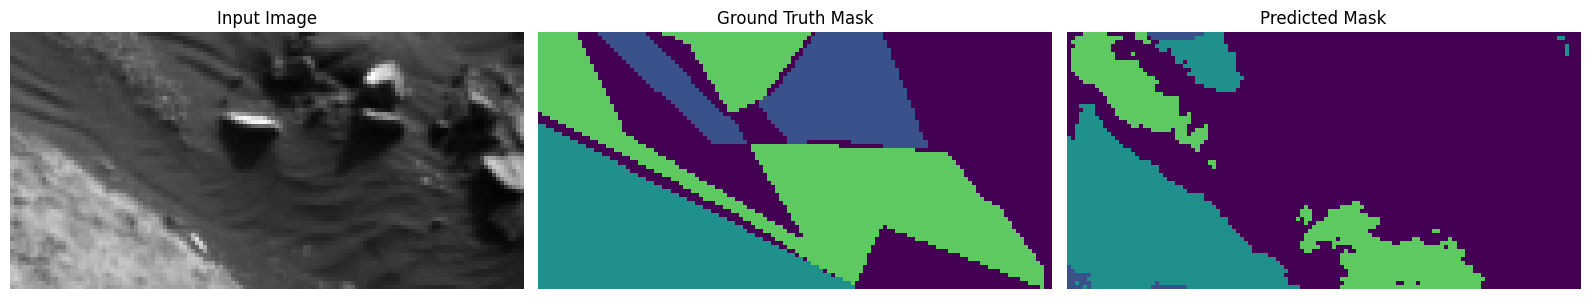

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6758 - loss: 0.8738 - mean_iou: 0.3914 - val_accuracy: 0.6644 - val_loss: 0.9501 - val_mean_iou: 0.3771 - learning_rate: 1.0000e-04
Epoch 17/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6776 - loss: 0.8603 - mean_iou: 0.3910 - val_accuracy: 0.6405 - val_loss: 0.9887 - val_mean_iou: 0.3447 - learning_rate: 1.0000e-04
Epoch 18/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6731 - loss: 0.8649 - mean_iou: 0.3855 - val_accuracy: 0.6667 - val_loss: 0.8987 - val_mean_iou: 0.3733 - learning_rate: 1.0000e-04
Epoch 19/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6733 - loss: 0.8654 - mean_iou: 0.3843 - val_accuracy: 0.6407 - val_loss: 0.9177 - val_mean_iou: 0.3397 - learning_rate: 1.0000e-04
Epoch 20/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6764 - loss: 0.8542 - mean_iou: 0.3879 - val_accuracy: 0.6933 - val_loss: 0.8418 - val_mean_iou: 0.4013 - learning_rate: 1.0000e-04
Epoch 21/1000


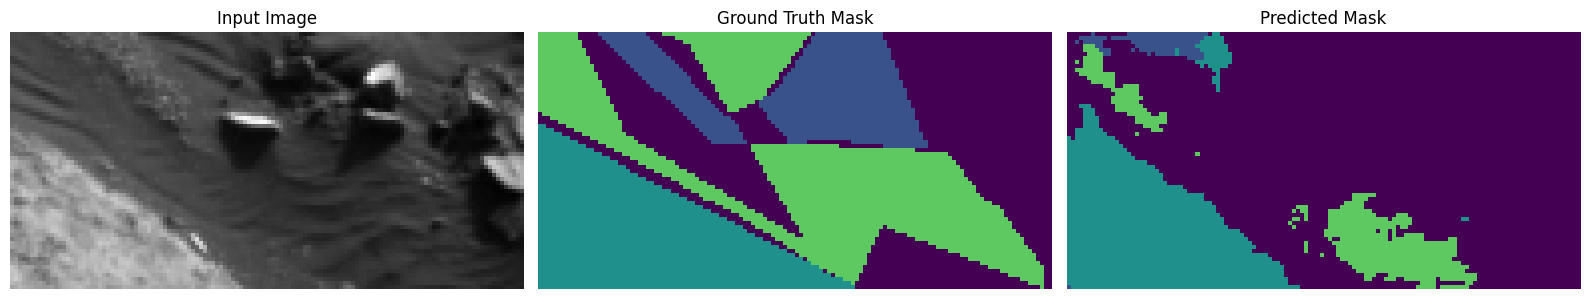

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6839 - loss: 0.8412 - mean_iou: 0.4013 - val_accuracy: 0.6664 - val_loss: 0.8800 - val_mean_iou: 0.3741 - learning_rate: 1.0000e-04
Epoch 22/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6818 - loss: 0.8374 - mean_iou: 0.4056 - val_accuracy: 0.6812 - val_loss: 0.8485 - val_mean_iou: 0.3886 - learning_rate: 1.0000e-04
Epoch 23/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6872 - loss: 0.8228 - mean_iou: 0.3954 - val_accuracy: 0.6840 - val_loss: 0.8530 - val_mean_iou: 0.3917 - learning_rate: 1.0000e-04
Epoch 24/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6926 - loss: 0.8150 - mean_iou: 0.4080 - val_accuracy: 0.6664 - val_loss: 0.8778 - val_mean_iou: 0.3625 - learning_rate: 1.0000e-04
Epoch 25/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6906 - loss: 0.8111 - mean_iou: 0.3999 - val_accuracy: 0.6823 - val_loss: 0.8492 - val_mean_iou: 0.3814 - learning_rate: 1.0000e-04
Epoch 26/1000


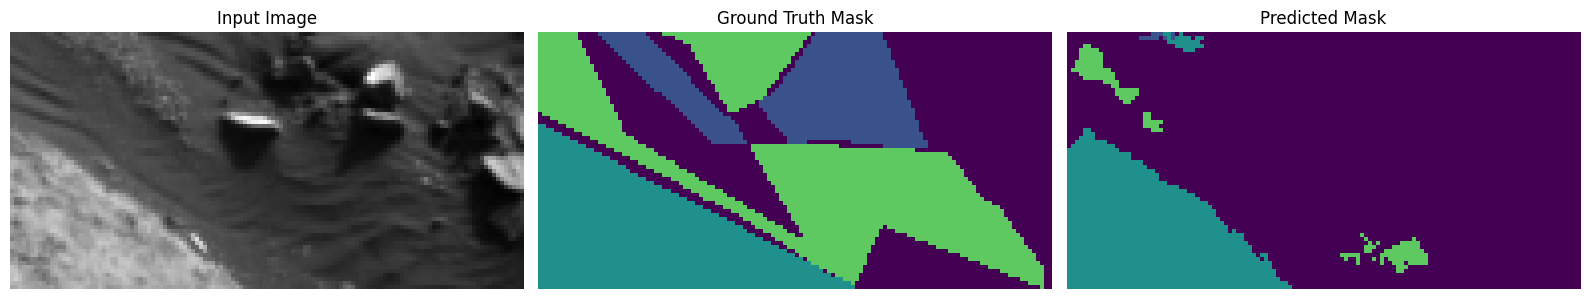

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6872 - loss: 0.8188 - mean_iou: 0.4015 - val_accuracy: 0.6469 - val_loss: 0.9272 - val_mean_iou: 0.3574 - learning_rate: 1.0000e-04
Epoch 27/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6942 - loss: 0.8012 - mean_iou: 0.4106 - val_accuracy: 0.6683 - val_loss: 0.8884 - val_mean_iou: 0.3794 - learning_rate: 1.0000e-04
Epoch 28/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6911 - loss: 0.8114 - mean_iou: 0.4074 - val_accuracy: 0.6908 - val_loss: 0.8375 - val_mean_iou: 0.3978 - learning_rate: 1.0000e-04
Epoch 29/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.6937 - loss: 0.8034 - mean_iou: 0.4108 - val_accuracy: 0.6998 - val_loss: 0.7896 - val_mean_iou: 0.4048 - learning_rate: 1.0000e-04
Epoch 30/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6958 - loss: 0.7988 - mean_iou: 0.4093 - val_accuracy: 0.6804 - val_loss: 0.8408 - val_mean_iou: 0.3836 - learning_rate: 1.0000e-04
Epoch 31/1000


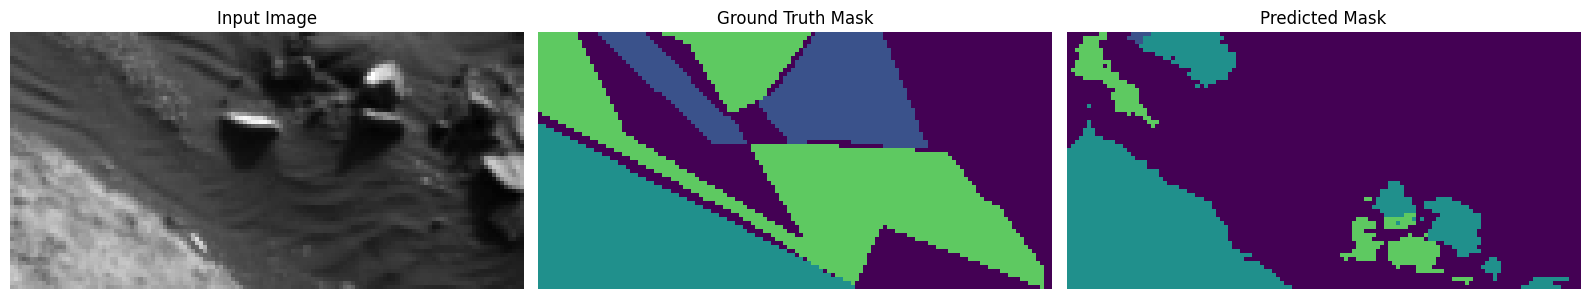

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.6986 - loss: 0.7901 - mean_iou: 0.4102 - val_accuracy: 0.6143 - val_loss: 1.0265 - val_mean_iou: 0.3186 - learning_rate: 1.0000e-04
Epoch 32/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6924 - loss: 0.8007 - mean_iou: 0.4075 - val_accuracy: 0.7052 - val_loss: 0.7924 - val_mean_iou: 0.4159 - learning_rate: 1.0000e-04
Epoch 33/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7017 - loss: 0.7781 - mean_iou: 0.4187 - val_accuracy: 0.6765 - val_loss: 0.8670 - val_mean_iou: 0.3768 - learning_rate: 1.0000e-04
Epoch 34/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6984 - loss: 0.7787 - mean_iou: 0.4171 - val_accuracy: 0.6815 - val_loss: 0.8436 - val_mean_iou: 0.3826 - learning_rate: 1.0000e-04
Epoch 35/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7056 - loss: 0.7703 - mean_iou: 0.4238 - val_accuracy: 0.7065 - val_loss: 0.7845 - val_mean_iou: 0.4091 - learning_rate: 1.0000e-04
Epoch 36/1000


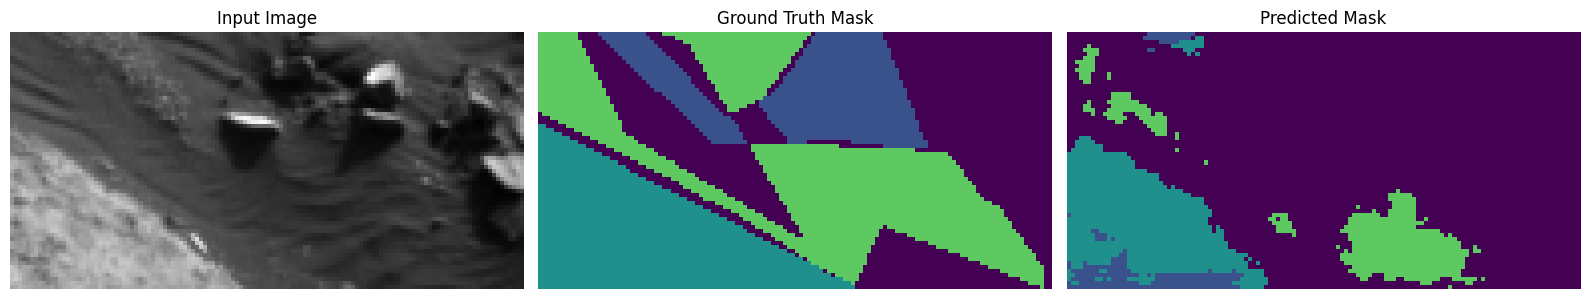

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7038 - loss: 0.7702 - mean_iou: 0.4205 - val_accuracy: 0.6604 - val_loss: 0.9114 - val_mean_iou: 0.3575 - learning_rate: 1.0000e-04
Epoch 37/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7055 - loss: 0.7672 - mean_iou: 0.4214 - val_accuracy: 0.6988 - val_loss: 0.8297 - val_mean_iou: 0.4021 - learning_rate: 1.0000e-04
Epoch 38/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7066 - loss: 0.7595 - mean_iou: 0.4236 - val_accuracy: 0.6582 - val_loss: 0.9976 - val_mean_iou: 0.3556 - learning_rate: 1.0000e-04
Epoch 39/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7107 - loss: 0.7482 - mean_iou: 0.4236 - val_accuracy: 0.6699 - val_loss: 0.9045 - val_mean_iou: 0.3749 - learning_rate: 1.0000e-04
Epoch 40/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7000 - loss: 0.7709 - mean_iou: 0.4168 - val_accuracy: 0.6728 - val_loss: 0.9229 - val_mean_iou: 0.3722 - learning_rate: 1.0000e-04
Epoch 41/1000


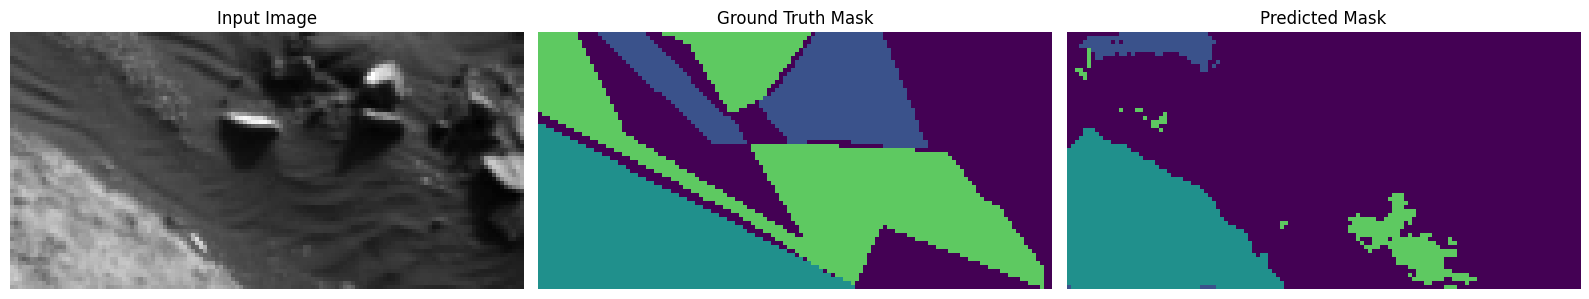

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7075 - loss: 0.7608 - mean_iou: 0.4233 - val_accuracy: 0.7035 - val_loss: 0.7771 - val_mean_iou: 0.4060 - learning_rate: 1.0000e-04
Epoch 42/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7136 - loss: 0.7500 - mean_iou: 0.4282 - val_accuracy: 0.7065 - val_loss: 0.7868 - val_mean_iou: 0.4095 - learning_rate: 1.0000e-04
Epoch 43/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7145 - loss: 0.7478 - mean_iou: 0.4253 - val_accuracy: 0.6818 - val_loss: 0.8412 - val_mean_iou: 0.3816 - learning_rate: 1.0000e-04
Epoch 44/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7160 - loss: 0.7448 - mean_iou: 0.4306 - val_accuracy: 0.6771 - val_loss: 0.8561 - val_mean_iou: 0.3708 - learning_rate: 1.0000e-04
Epoch 45/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7087 - loss: 0.7547 - mean_iou: 0.4163 - val_accuracy: 0.6858 - val_loss: 0.8180 - val_mean_iou: 0.3782 - learning_rate: 1.0000e-04
Epoch 46/1000


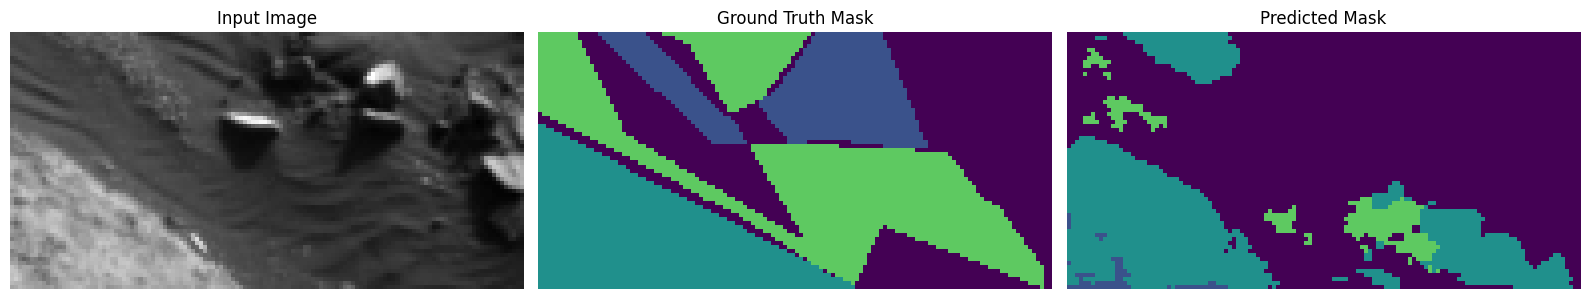

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7148 - loss: 0.7339 - mean_iou: 0.4346 - val_accuracy: 0.7030 - val_loss: 0.7906 - val_mean_iou: 0.3998 - learning_rate: 1.0000e-04
Epoch 47/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7190 - loss: 0.7304 - mean_iou: 0.4328 - val_accuracy: 0.7115 - val_loss: 0.7651 - val_mean_iou: 0.4178 - learning_rate: 1.0000e-04
Epoch 48/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7064 - loss: 0.7544 - mean_iou: 0.4129 - val_accuracy: 0.6989 - val_loss: 0.8127 - val_mean_iou: 0.4063 - learning_rate: 1.0000e-04
Epoch 49/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7157 - loss: 0.7406 - mean_iou: 0.4313 - val_accuracy: 0.6925 - val_loss: 0.8490 - val_mean_iou: 0.3959 - learning_rate: 1.0000e-04
Epoch 50/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7166 - loss: 0.7316 - mean_iou: 0.4278 - val_accuracy: 0.7117 - val_loss: 0.7564 - val_mean_iou: 0.4190 - learning_rate: 1.0000e-04
Epoch 51/1000


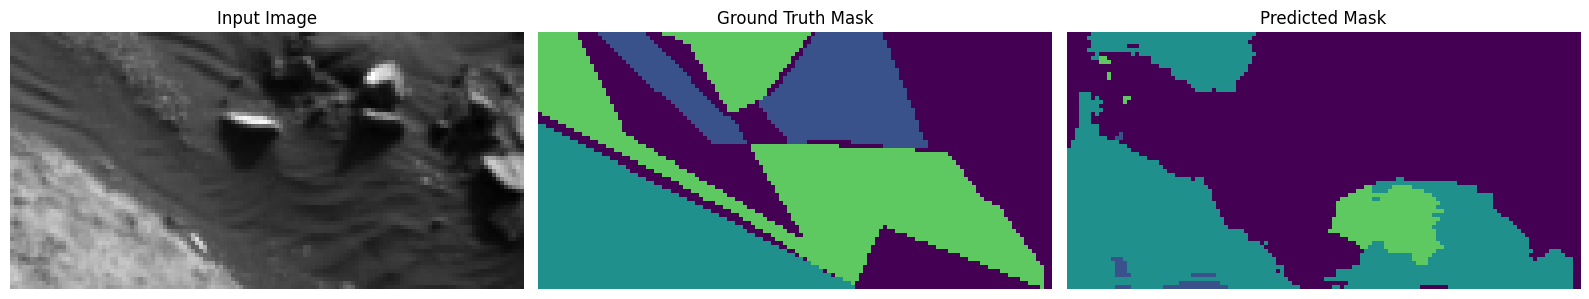

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7188 - loss: 0.7248 - mean_iou: 0.4334 - val_accuracy: 0.7178 - val_loss: 0.7477 - val_mean_iou: 0.4238 - learning_rate: 1.0000e-04
Epoch 52/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7216 - loss: 0.7192 - mean_iou: 0.4346 - val_accuracy: 0.6896 - val_loss: 0.8170 - val_mean_iou: 0.3808 - learning_rate: 1.0000e-04
Epoch 53/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7205 - loss: 0.7245 - mean_iou: 0.4289 - val_accuracy: 0.7095 - val_loss: 0.7646 - val_mean_iou: 0.4158 - learning_rate: 1.0000e-04
Epoch 54/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7253 - loss: 0.7110 - mean_iou: 0.4378 - val_accuracy: 0.6051 - val_loss: 1.0452 - val_mean_iou: 0.3181 - learning_rate: 1.0000e-04
Epoch 55/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7187 - loss: 0.7308 - mean_iou: 0.4333 - val_accuracy: 0.6559 - val_loss: 0.9004 - val_mean_iou: 0.3627 - learning_rate: 1.0000e-04
Epoch 56/1000


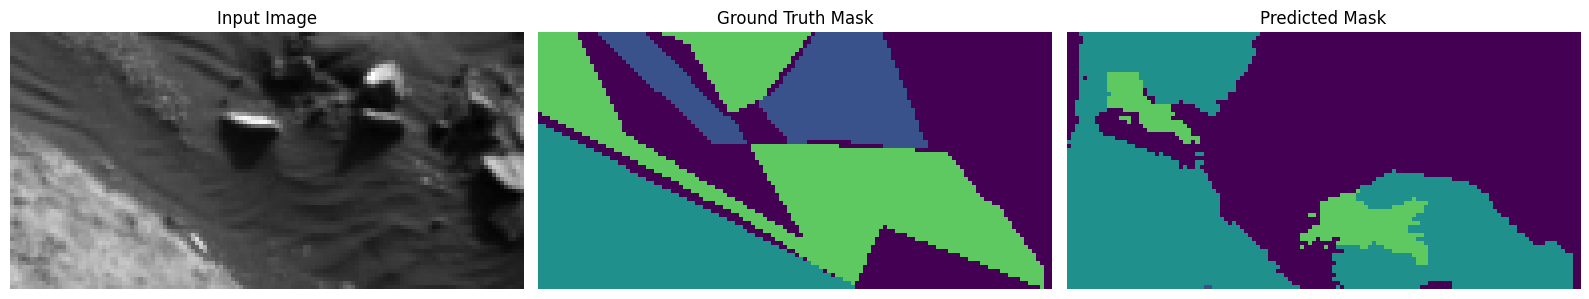

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7258 - loss: 0.7129 - mean_iou: 0.4422 - val_accuracy: 0.7091 - val_loss: 0.7700 - val_mean_iou: 0.4150 - learning_rate: 1.0000e-04
Epoch 57/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7213 - loss: 0.7228 - mean_iou: 0.4347 - val_accuracy: 0.7045 - val_loss: 0.7796 - val_mean_iou: 0.4017 - learning_rate: 1.0000e-04
Epoch 58/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7227 - loss: 0.7149 - mean_iou: 0.4338 - val_accuracy: 0.6932 - val_loss: 0.7833 - val_mean_iou: 0.3898 - learning_rate: 1.0000e-04
Epoch 59/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7262 - loss: 0.7080 - mean_iou: 0.4406 - val_accuracy: 0.7040 - val_loss: 0.7804 - val_mean_iou: 0.4104 - learning_rate: 1.0000e-04
Epoch 60/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7269 - loss: 0.7039 - mean_iou: 0.4383 - val_accuracy: 0.7077 - val_loss: 0.7628 - val_mean_iou: 0.4138 - learning_rate: 1.0000e-04
Epoch 61/1000


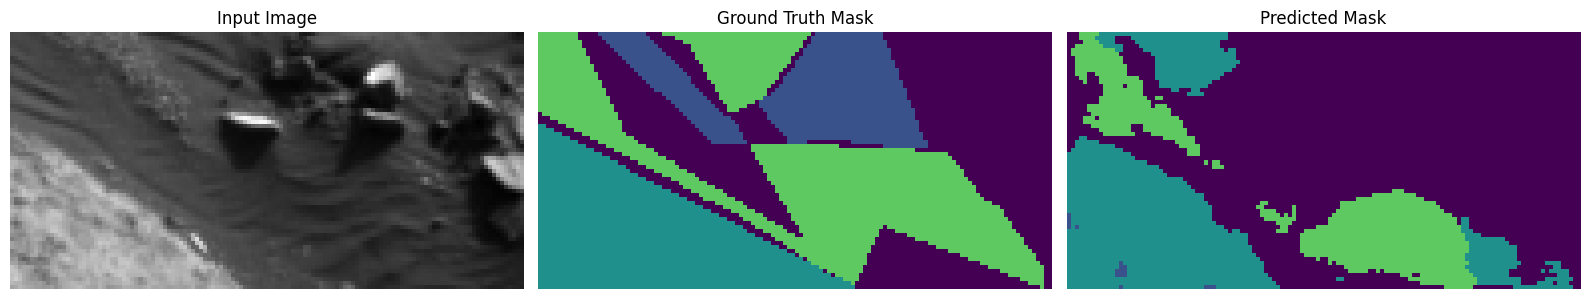

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7262 - loss: 0.7063 - mean_iou: 0.4398 - val_accuracy: 0.7133 - val_loss: 0.7676 - val_mean_iou: 0.4139 - learning_rate: 1.0000e-04
Epoch 62/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7296 - loss: 0.6996 - mean_iou: 0.4384 - val_accuracy: 0.7281 - val_loss: 0.7089 - val_mean_iou: 0.4349 - learning_rate: 1.0000e-05
Epoch 63/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7333 - loss: 0.6854 - mean_iou: 0.4506 - val_accuracy: 0.7283 - val_loss: 0.7039 - val_mean_iou: 0.4358 - learning_rate: 1.0000e-05
Epoch 64/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7371 - loss: 0.6778 - mean_iou: 0.4519 - val_accuracy: 0.7301 - val_loss: 0.6997 - val_mean_iou: 0.4374 - learning_rate: 1.0000e-05
Epoch 65/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7322 - loss: 0.6915 - mean_iou: 0.4475 - val_accuracy: 0.7301 - val_loss: 0.7022 - val_mean_iou: 0.4371 - learning_rate: 1.0000e-05
Epoch 66/1000


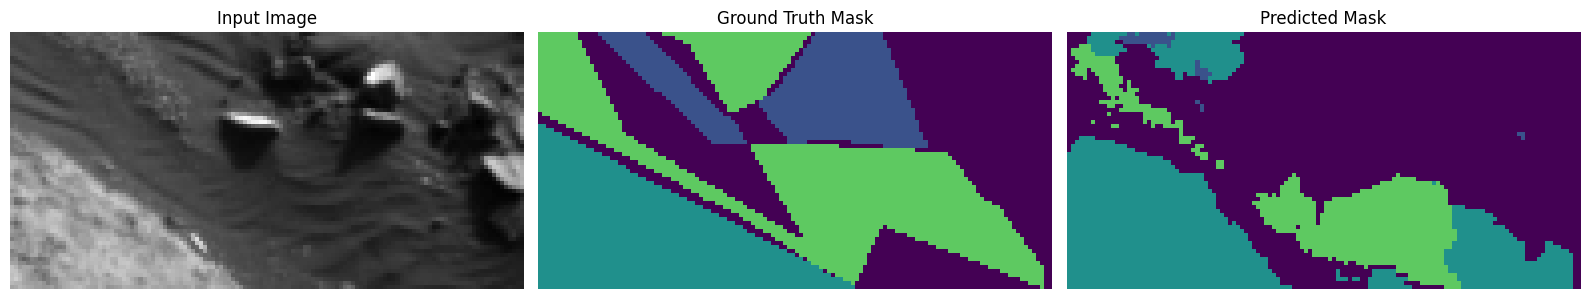

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7383 - loss: 0.6768 - mean_iou: 0.4547 - val_accuracy: 0.7286 - val_loss: 0.7030 - val_mean_iou: 0.4350 - learning_rate: 1.0000e-05
Epoch 67/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7367 - loss: 0.6823 - mean_iou: 0.4504 - val_accuracy: 0.7277 - val_loss: 0.7025 - val_mean_iou: 0.4338 - learning_rate: 1.0000e-05
Epoch 68/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7407 - loss: 0.6721 - mean_iou: 0.4569 - val_accuracy: 0.7292 - val_loss: 0.7007 - val_mean_iou: 0.4359 - learning_rate: 1.0000e-05
Epoch 69/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7360 - loss: 0.6796 - mean_iou: 0.4519 - val_accuracy: 0.7295 - val_loss: 0.7004 - val_mean_iou: 0.4362 - learning_rate: 1.0000e-05
Epoch 70/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7347 - loss: 0.6851 - mean_iou: 0.4505 - val_accuracy: 0.7301 - val_loss: 0.6992 - val_mean_iou: 0.4350 - learning_rate: 1.0000e-05
Epoch 71/1000


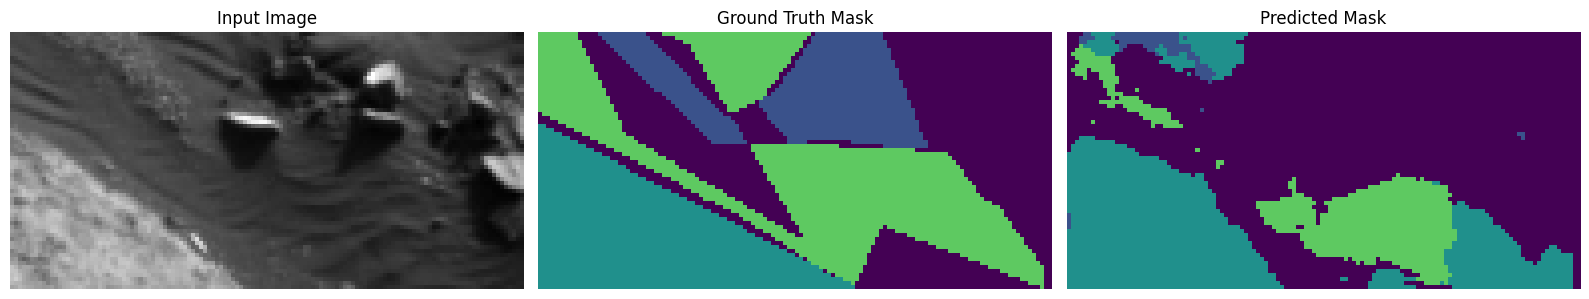

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.7357 - loss: 0.6815 - mean_iou: 0.4493 - val_accuracy: 0.7303 - val_loss: 0.6979 - val_mean_iou: 0.4366 - learning_rate: 1.0000e-05
Epoch 72/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7359 - loss: 0.6832 - mean_iou: 0.4517 - val_accuracy: 0.7305 - val_loss: 0.6984 - val_mean_iou: 0.4368 - learning_rate: 1.0000e-05
Epoch 73/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7387 - loss: 0.6719 - mean_iou: 0.4558 - val_accuracy: 0.7307 - val_loss: 0.6999 - val_mean_iou: 0.4384 - learning_rate: 1.0000e-05
Epoch 74/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7436 - loss: 0.6660 - mean_iou: 0.4578 - val_accuracy: 0.7310 - val_loss: 0.6971 - val_mean_iou: 0.4378 - learning_rate: 1.0000e-05
Epoch 75/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7394 - loss: 0.6772 - mean_iou: 0.4558 - val_accuracy: 0.7303 - val_loss: 0.6976 - val_mean_iou: 0.4367 - learning_rate: 1.0000e-05
Epoch 76/1000


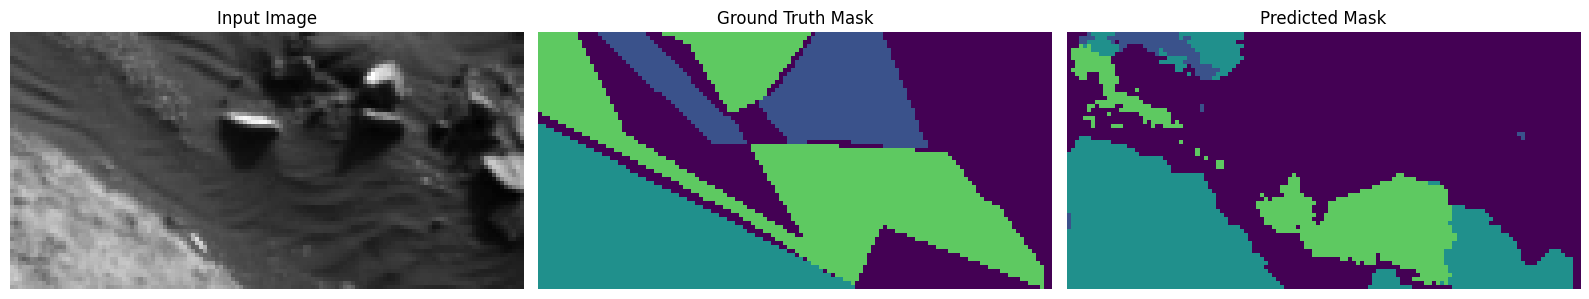

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.7387 - loss: 0.6725 - mean_iou: 0.4524 - val_accuracy: 0.7300 - val_loss: 0.6967 - val_mean_iou: 0.4346 - learning_rate: 1.0000e-05
Epoch 77/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7424 - loss: 0.6688 - mean_iou: 0.4561 - val_accuracy: 0.7317 - val_loss: 0.6963 - val_mean_iou: 0.4378 - learning_rate: 1.0000e-05
Epoch 78/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7420 - loss: 0.6647 - mean_iou: 0.4627 - val_accuracy: 0.7312 - val_loss: 0.6957 - val_mean_iou: 0.4387 - learning_rate: 1.0000e-05
Epoch 79/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7407 - loss: 0.6725 - mean_iou: 0.4545 - val_accuracy: 0.7302 - val_loss: 0.6969 - val_mean_iou: 0.4361 - learning_rate: 1.0000e-05
Epoch 80/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7354 - loss: 0.6741 - mean_iou: 0.4457 - val_accuracy: 0.7305 - val_loss: 0.6959 - val_mean_iou: 0.4360 - learning_rate: 1.0000e-05
Epoch 81/1000


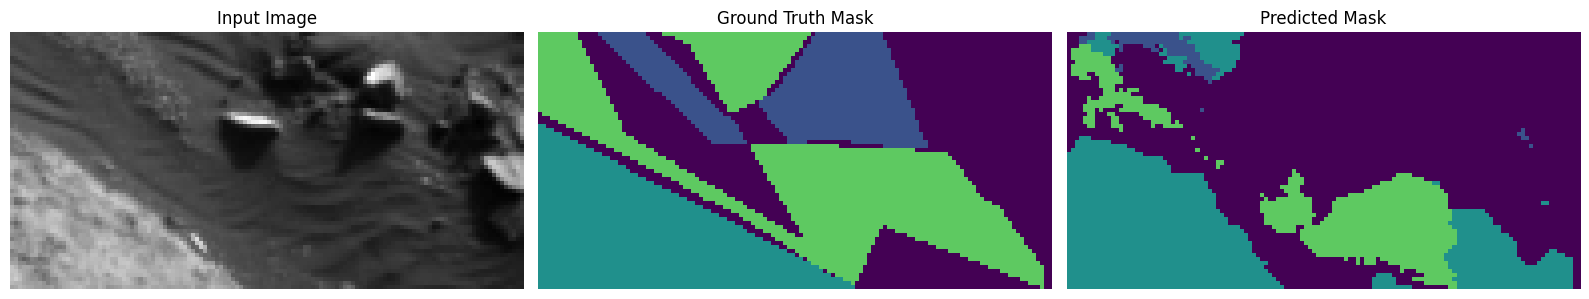

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7395 - loss: 0.6724 - mean_iou: 0.4556 - val_accuracy: 0.7303 - val_loss: 0.6952 - val_mean_iou: 0.4352 - learning_rate: 1.0000e-05
Epoch 82/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7409 - loss: 0.6720 - mean_iou: 0.4516 - val_accuracy: 0.7306 - val_loss: 0.6954 - val_mean_iou: 0.4347 - learning_rate: 1.0000e-05
Epoch 83/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7390 - loss: 0.6759 - mean_iou: 0.4522 - val_accuracy: 0.7317 - val_loss: 0.6934 - val_mean_iou: 0.4378 - learning_rate: 1.0000e-05
Epoch 84/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7419 - loss: 0.6661 - mean_iou: 0.4550 - val_accuracy: 0.7314 - val_loss: 0.6951 - val_mean_iou: 0.4387 - learning_rate: 1.0000e-05
Epoch 85/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7354 - loss: 0.6823 - mean_iou: 0.4517 - val_accuracy: 0.7293 - val_loss: 0.6992 - val_mean_iou: 0.4341 - learning_rate: 1.0000e-05
Epoch 86/1000


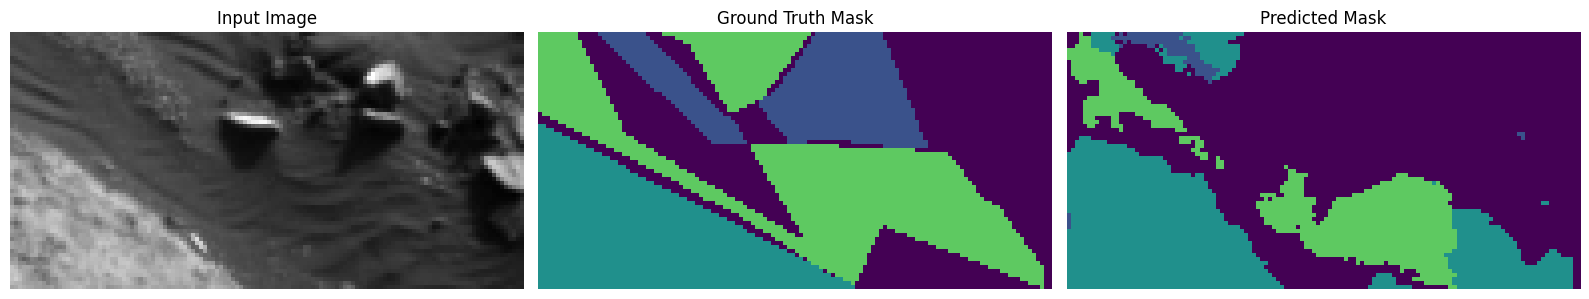

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7399 - loss: 0.6686 - mean_iou: 0.4563 - val_accuracy: 0.7297 - val_loss: 0.6981 - val_mean_iou: 0.4345 - learning_rate: 1.0000e-05
Epoch 87/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7411 - loss: 0.6725 - mean_iou: 0.4589 - val_accuracy: 0.7307 - val_loss: 0.7003 - val_mean_iou: 0.4356 - learning_rate: 1.0000e-05
Epoch 88/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7399 - loss: 0.6712 - mean_iou: 0.4567 - val_accuracy: 0.7310 - val_loss: 0.6970 - val_mean_iou: 0.4362 - learning_rate: 1.0000e-05
Epoch 89/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7409 - loss: 0.6668 - mean_iou: 0.4564 - val_accuracy: 0.7309 - val_loss: 0.6955 - val_mean_iou: 0.4365 - learning_rate: 1.0000e-05
Epoch 90/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7422 - loss: 0.6637 - mean_iou: 0.4607 - val_accuracy: 0.7304 - val_loss: 0.6959 - val_mean_iou: 0.4347 - learning_rate: 1.0000e-05
Epoch 91/1000


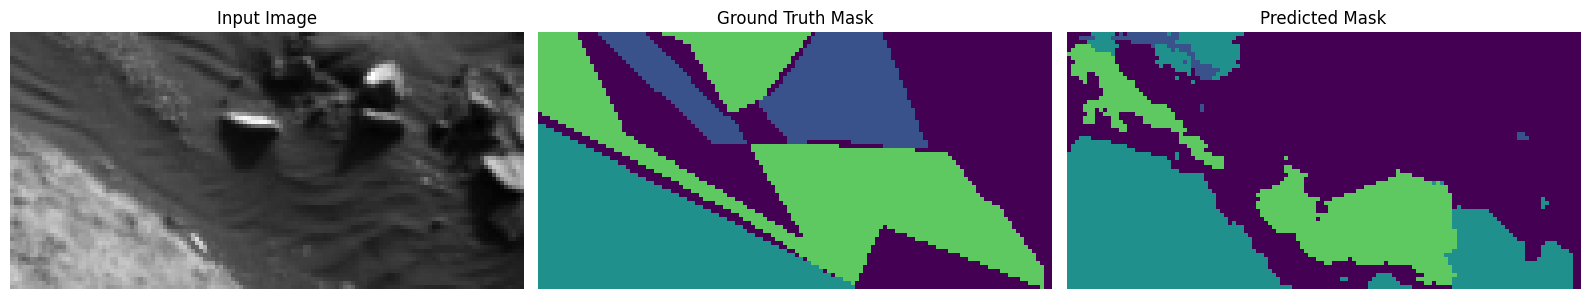

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7397 - loss: 0.6730 - mean_iou: 0.4555 - val_accuracy: 0.7311 - val_loss: 0.6943 - val_mean_iou: 0.4375 - learning_rate: 1.0000e-05
Epoch 92/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7367 - loss: 0.6769 - mean_iou: 0.4460 - val_accuracy: 0.7309 - val_loss: 0.6976 - val_mean_iou: 0.4362 - learning_rate: 1.0000e-05
Epoch 93/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.7372 - loss: 0.6746 - mean_iou: 0.4524 - val_accuracy: 0.7303 - val_loss: 0.6981 - val_mean_iou: 0.4354 - learning_rate: 1.0000e-05
Epoch 94/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7432 - loss: 0.6614 - mean_iou: 0.4603 - val_accuracy: 0.7309 - val_loss: 0.6955 - val_mean_iou: 0.4371 - learning_rate: 1.0000e-06
Epoch 95/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7447 - loss: 0.6557 - mean_iou: 0.4650 - val_accuracy: 0.7313 - val_loss: 0.6942 - val_mean_iou: 0.4375 - learning_rate: 1.0000e-06
Epoch 96/1000


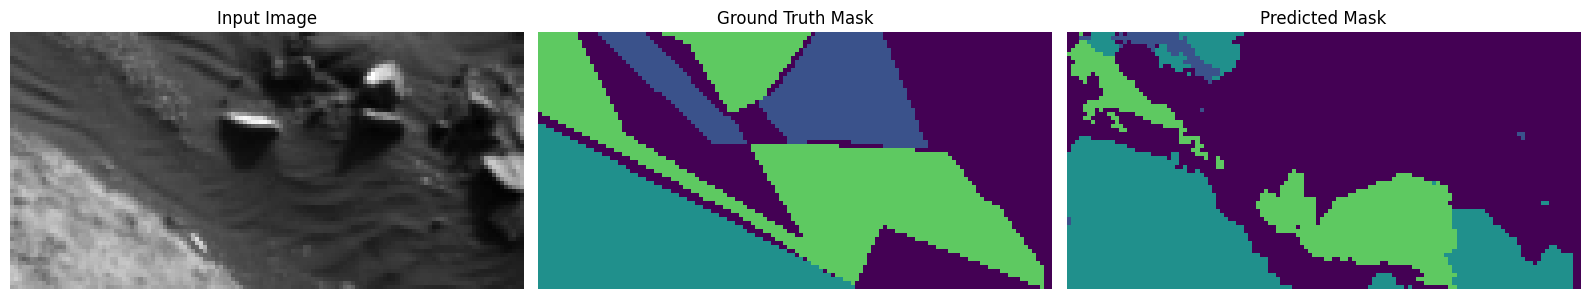

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.7402 - loss: 0.6718 - mean_iou: 0.4539 - val_accuracy: 0.7316 - val_loss: 0.6936 - val_mean_iou: 0.4378 - learning_rate: 1.0000e-06
Epoch 97/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7478 - loss: 0.6536 - mean_iou: 0.4632 - val_accuracy: 0.7314 - val_loss: 0.6938 - val_mean_iou: 0.4377 - learning_rate: 1.0000e-06
Epoch 98/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7428 - loss: 0.6666 - mean_iou: 0.4571 - val_accuracy: 0.7315 - val_loss: 0.6940 - val_mean_iou: 0.4378 - learning_rate: 1.0000e-06
Epoch 99/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7409 - loss: 0.6720 - mean_iou: 0.4592 - val_accuracy: 0.7314 - val_loss: 0.6935 - val_mean_iou: 0.4379 - learning_rate: 1.0000e-06
Epoch 100/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.7434 - loss: 0.6644 - mean_iou: 0.4565 - val_accuracy: 0.7318 - val_loss: 0.6931 - val_mean_iou: 0.4381 - learning_rate: 1.0000e-06
Epoch 101/100

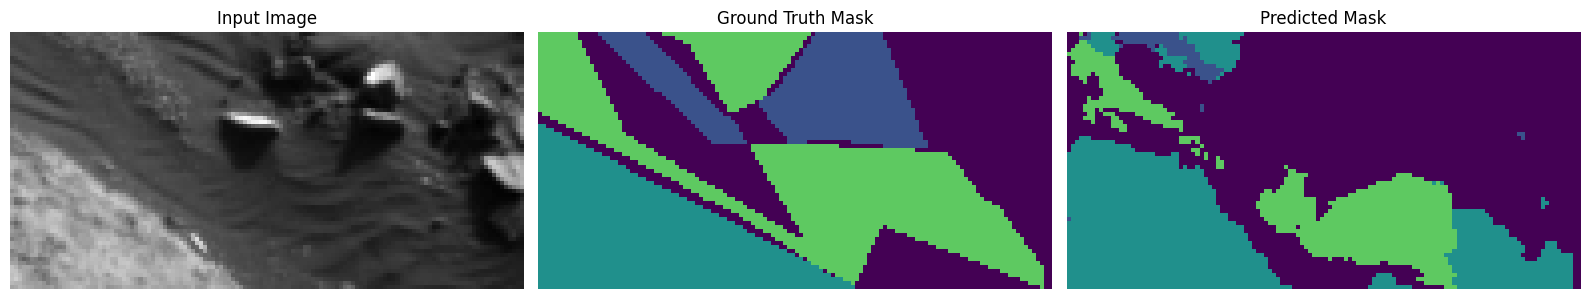

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7449 - loss: 0.6583 - mean_iou: 0.4625 - val_accuracy: 0.7316 - val_loss: 0.6935 - val_mean_iou: 0.4380 - learning_rate: 1.0000e-06
Epoch 102/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7413 - loss: 0.6670 - mean_iou: 0.4502 - val_accuracy: 0.7316 - val_loss: 0.6935 - val_mean_iou: 0.4381 - learning_rate: 1.0000e-06
Epoch 103/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7433 - loss: 0.6620 - mean_iou: 0.4588 - val_accuracy: 0.7317 - val_loss: 0.6936 - val_mean_iou: 0.4383 - learning_rate: 1.0000e-06
Epoch 104/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7431 - loss: 0.6628 - mean_iou: 0.4606 - val_accuracy: 0.7317 - val_loss: 0.6937 - val_mean_iou: 0.4383 - learning_rate: 1.0000e-06
Final validation Mean Intersection Over Union: 43.87%


In [21]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1,
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history["val_mean_iou"]) * 100, 2)
print(f"Final validation Mean Intersection Over Union: {final_val_meanIoU}%")

In [22]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241204_182848.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [23]:
"""
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")
"""

'\n# If model_filename is not defined, load the most recent model from Google Drive\nif "model_filename" not in globals() or model_filename is None:\n    files = [f for f in os.listdir(\'.\') if os.path.isfile(f) and f.startswith(\'model_\') and f.endswith(\'.keras\')]\n    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)\n    if files:\n        model_filename = files[0]\n    else:\n        raise FileNotFoundError("No model files found in the current directory.")\n'

In [24]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241204_182848.keras


In [25]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


2024-12-04 18:28:57.869320: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1642004480 exceeds 10% of free system memory.


Predictions shape: (10022, 64, 128)


In [26]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [27]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

# from google.colab import files
# files.download(submission_filename)

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```